# Alignment to ancestors

We recommend performing the ancestral inference in a high-performance computing environment. Therefore, this Colab notebook serves as an example for the user to visualize the effects of manipulating parameters for ancestral reconstruction on topiary's toy dataset without need for a computing cluster.

Because of different parallelization requirements, the ancestral inference step uses two scripts run in sequence (alignment-to-ancestors and bootstrap-reconcile). The first script infers the evolutionary model, builds the maximum likelkihood (ML) gene tree, reconciles the ML gene tree with the species tree, reconstructs ancestors, and generates bootstrap pseudoreplicates of the ML tree for statistical analysis in the bootstrap-reconcile script. The results produced from each of these processes in alignment-to-ancestors can be visualized as summary tree PDF files written out at each step. Reconstructing ancestors should take about a day for a reasonable alignment (1,000 columns, 500 sequences) running on a reasonable compute node (30 cores). 

The bootstrap-reconcile script reconciles each pseudoreplicate gene tree to the species tree and constructs the final branch supports. Bootstrap sampling the gene-species reconciliation is computationally intensive but can be readily parallelized. For a full alignemnt, it will likely take approximately a week spread across several cores.


In [ ]:
#@title Install software

#@markdown Install the software by pressing the _Play_ button on the left.
#@markdown Please be patient. This will take several minutes. After the 
#@markdown installation is complete, the kernel will reboot and colab will
#@markdown complain that the kernel has died. The time bar will indicate that
#@markdown only 83% of the install has completed and Colab will give you a 
#@markdown message that "Your session has crashed for an unkonwn reason." This 
#@markdown is normal and your install is indeed complete. 

install_raxml = True #@param {type:"boolean"}
install_generax = True #@param {type:"boolean"}

# This assumes python 3.8 (the current collab default, 2022/12/07)
# If collab updates from python 3.8, change:

# 1. Miniconda3-py38_4.12.0-Linux-x86_64.sh
# 2. conda install --channel defaults conda python=3.8 --yes
# 3. Refs to /usr/local/lib/python3.8/site-packages

# Change these in both the "Install" and "Initialize" cells


from tqdm.auto import tqdm
import sys
import subprocess
import time
import os

def run_install_cmd(bash_to_run,title,step_number):

  os.chdir("software")

  print(f"{title}... ",end="",flush=True)
  f = open(f"{step_number}_tmp-script.sh","w")
  f.write(bash_to_run)
  f.close()

  result = subprocess.run(["bash",f"{step_number}_tmp-script.sh"],
                          stdout=subprocess.PIPE,
                          stderr=subprocess.PIPE,
                          text=True)
  
  if result.returncode != 0:
    print(result.stdout,flush=True)
    print(result.stderr,flush=True)
    raise RuntimeError("Installation failed!")

  
  f = open(f"{step_number}_stdout.txt","w")
  f.write(result.stdout)
  f.close()

  f = open(f"{step_number}_stderr.txt","w")
  f.write(result.stderr)
  f.close()

  os.chdir("..")

  print("Complete.",flush=True)

  
miniconda = \
"""
unset PYTHONPATH
MINICONDA_INSTALLER_SCRIPT=Miniconda3-py38_4.12.0-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.anaconda.com/miniconda/$MINICONDA_INSTALLER_SCRIPT --quiet
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX
conda install --channel defaults conda python=3.8 --yes
conda update --channel defaults --all --yes
"""

conda_packages = \
"""
conda config --add channels conda-forge
conda config --add channels bioconda
conda install --channel defaults numpy pandas xlrd openpyxl matplotlib "muscle>=5.0" blast --yes --strict-channel-priority
"""

pip_packages = \
"""
# Install ghostscript binary (so toyplot doesn't complain)
wget https://github.com/ArtifexSoftware/ghostpdl-downloads/releases/download/gs1000/ghostscript-10.0.0-linux-x86_64.tgz
tar -zxf ghostscript-10.0.0-linux-x86_64.tgz
mv ghostscript-10.0.0-linux-x86_64/gs-1000-linux-x86_64 /usr/local/bin/gs

/usr/bin/python3 -m pip install mpi4py opentree ete3 dendropy biopython pastml toytree toyplot 
"""

raxml = \
"""
wget https://github.com/amkozlov/raxml-ng/releases/download/1.1.0/raxml-ng_v1.1.0_linux_x86_64.zip
unzip raxml-ng_v1.1.0_linux_x86_64.zip
cp raxml-ng /usr/local/bin
"""

generax = \
"""
apt-get install flex bison libgmp3-dev
rm -rf GeneRax
git clone --recursive https://github.com/BenoitMorel/GeneRax
cd GeneRax
./install.sh
cp build/bin/generax /usr/local/bin
cd ..
"""

topiary = \
"""
rm -rf topiary
git clone --branch main https://github.com/harmsm/topiary.git

cd topiary

# add --allow-run-as-root to mpirun calls
for x in `echo "./topiary/generax/_generax.py ./topiary/generax/_reconcile_bootstrap.py ./topiary/_private/mpi/mpi.py"`; do
  sed -i 's/\[\"mpirun\",/\[\"mpirun\",\"--allow-run-as-root\",/g' ${x}
done

/usr/bin/python3 -m pip install . -vv
cd ..
"""

description_list = ["Download and install miniconda",
                    "Install conda packages",
                    "Install pip packages"]
         
cmd_list = [miniconda,
            conda_packages,
            pip_packages]

if install_raxml:
  description_list.append("Install raxml-ng")
  cmd_list.append(raxml)

if install_generax:
  description_list.append("Install generax")
  cmd_list.append(generax)

description_list.append("Install topiary")
cmd_list.append(topiary)


!rm -rf software
!mkdir software

for i in tqdm(range(len(cmd_list))):
  run_install_cmd(cmd_list[i],description_list[i],i)
  if i == 0:

    # Add conda path to the current python session
    sys.path.append("/usr/local/lib/python3.8/site-packages")

    # Make sure that any new python session that spools up has the correct site
    # packages. (For subsequent pip installs)
    f = open("/content/software/python_startup.py","w")
    f.write("import sys\n")
    f.write("sys.path.append('/usr/local/lib/python3.8/site-packages')\n")
    f.close()

    # Set python startup script. 
    %env PYTHONSTARTUP=/contents/software/python_startup.py

os._exit(00)


In [ ]:
#@title Initialize environment

#@markdown  Run this cell to initialize the environment after installation.
#@markdown (This cell can also be run if the kernel dies during a calculation,
#@markdown allowing you to reload modules without having to
#@markdown reinstall). 

%env PYTHONPATH=""
%env PYTHONSTARTUP=/contents/software/python_startup.py
%env TOPIARY_MAX_SLOTS=1

from tqdm.auto import tqdm
import sys
import subprocess
import time
import os

to_append = '/usr/local/lib/python3.8/site-packages'
if to_append not in sys.path:
  sys.path.append(to_append)

import topiary
topiary._in_notebook = True

import numpy as np
import pandas as pd 

os.chdir("/content/")


In [ ]:
#@title Run the alignment_to_ancestors pipeline.

#@markdown This pipeline takes the alignment, finds the best phylogenetic model
#@markdown to explain relationships of sequences in the alignment, builds a
#@markdown maximum likelihood tree, reconciles this tree with the species tree,
#@markdown and then infers ancestral proteins.
#@markdown 
#@markdown The following parameters can be manipulated.
#@markdown 
#@markdown If reconstructing microbe-specific ancestral proteins, reconciling
#@markdown your gene tree with the species tree might not improve the confidence
#@markdown in the final tree. In this case, you can skip the reconciliation steps 
#@markdown by setting the "no_reconcile" parameter to "True".

alignment_file = "software/topiary/tests/data/tiny-phylo/00_find-best-model/input/dataframe.csv"
#species_tree = "software/topiary/tests/data/tiny-phylo/initial-input/species-tree.newick"

out_dir=None #@param {type: "string"}
starting_tree=None #@param {type: "string"}
#bootstrap=True #@param {type: "boolean"}
#no_bootstrap=False #@param {type: "boolean"}
#no_reconcile=False #@param {type: "boolean"}
#allow_horizontal_transfer=False #@param {type: "boolean"}
#no_horizontal_transfer=True #@param {type: "boolean"}
alt_cutoff=0.25 #@param {type:"number"}
model_matrices=["cpREV","Dayhoff","DCMut","DEN","Blosum62","FLU","HIVb","HIVw","JTT","JTT-DCMut","LG","mtART","mtMAM","mtREV","mtZOA","PMB","rtREV","stmtREV","VT","WAG"] #@param {type: "string"}
model_rates=["","G8"] #@param {type: "string"}
model_freqs=["","FC","FO"] #@param {type: "string"}
model_invariant=["","IC","IO"] #@param {type: "string"}
#restart=False #@param {type: "boolean"}
overwrite=False #@param {type: "boolean"}
num_threads=-1 #@param {type: "integer"}

topiary.alignment_to_ancestors(df=alignment_file,
                      out_dir=out_dir,
                      starting_tree=starting_tree,
                      #species_tree=species_tree,
                      #bootstrap=bootstrap,
                      #no_bootstrap=no_bootstrap,
                      #no_reconcile=no_reconcile,
                      #allow_horizontal_transfer=allow_horizontal_transfer,
                      #no_horizontal_transfer=no_horizontal_transfer,
                      alt_cutoff=alt_cutoff,
                      model_matrices=model_matrices,
                      model_rates=model_rates,
                      model_freqs=model_freqs,
                      model_invariant=model_invariant,
                      #restart=restart,
                      overwrite=overwrite,
                      num_threads=num_threads,
                      #raxml_binary=RAXML_BINARY,
                      #generax_binary=GENERAX_BINARY
                      )


### Argument definitions and default parameters for reference:  
---------- 
**df** : *pandas.DataFrame or str*
<br> Topiary data frame or csv written out from topiary df.

**out_dir** : *str, optional*
<br> Output directory. If not specified, create an output directory with the format "alignment_to_ancestors_{randomletters}".

**starting_tree** : *str, optional*
<br> Tree in newick format. This will be used for the best model inference and starting tree for the maximum likelihood tree estimation. If not specified, the maximum parsimony tree is generated and used.

**no_bootstrap** : *bool, default=False*
<br> Do not do bootstrap replicates.

**no_reconcile** : *bool, default=False*
<br> Do not reconcile gene and species trees.

**no_horizontal_transfer** : *bool, default=False*
<br> Whether to allow horizontal transfer during reconciliation. Default is to allow transfer (UndatedDTL; recommended). If flat set, use UndatedDL model.

**alt_cutoff** : *float, default=0.25*
<br> Cutoff to use for altAll alternate ancestral protein sequence generation. Should be between 0 and 1.

**model_matrices** : *list, default=["cpREV","Dayhoff","DCMut","DEN","Blosum62","FLU","HIVb","HIVw","JTT","JTT-DCMut","LG","mtART","mtMAM","mtREV","mtZOA","PMB","rtREV","stmtREV","VT","WAG"]*
<br> List of model matrices to check. If calling from command line, these can be specified directly (:code:`--model_matrices LG ...`) or by specifying a file with models on each line (:code:`--model_matrices SOME_FILE`).

**model_rates** : *list, default=["","G8"]*
<br> Ways to treat model rates. If calling from command line, these can be specified directly (:code:`--model_rates G8 ...`) or by specifying a file with rates on each line (:code:`--model_rates SOME_FILE`).

**model_freqs** : *list, default=["","FC","FO"]*
<br> Ways to treat model freqs. If calling from command line, these can be specified directly (:code:`--model_freqs FC FO ...`) or by specifying a file with freqs on each line (:code:`--model_freqs SOME_FILE`).

**model_invariant** : *list, default=["","IC","IO"]*
<br> Ways to treat invariant alignment columns. If calling from command line, these can be specified directly (:code:`--model_invariant IC IO ...`) or by specifying a file with invariants on each line (:code:`--model_invariant SOME_FILE`).

**restart** : *bool, default=False*
<br> Restart job from where it stopped in output directory. incompatible with overwrite.

**overwrite** : *bool, default=False*
<br> Whether or not to overwrite existing output. incompatible with restart.

**num_threads** : *int, default=-1*
<br> Number of threads to use. if -1 use all available.

**raxml_binary** : *str, optional*
<br> RAxML binary to use.

**generax_binary** : *str, optional*
<br> What generax binary to use.

---------- 



## Check for model violation

Topiary writes out summary tree PDFs sequentially as each step completes. We recommend evaluating these trees as they complete — particularly before the last, computationally-intensive step.

The most important tree to check in this process is the reconciled tree, as this can identify model violations that make it impossible to reconstruct ancestral sequences. The probabilistic models used in ASR are powerful, but do not capture all possible evolutionary events. One common problem is incomplete lineage sorting (ILS), where a gene duplicates but exists as several variants in a population when speciation occurs (45). Different duplicates are preserved along the descendant lineages, meaning this cannot be classified as a simple duplication or speciation event. ILS is a general problem with all ASR methods and is specifically noted as being outside the scope of GeneRax (21). Another problem is gene fusion, where different parts of a single gene have different evolutionary histories. The methods used by topiary all assume a single genetic history for each protein sequence. If we force such a model to fit a fused alignment, we will likely end up with a nonsensical evolutionary tree and meaningless ancestral sequences.

In the worst case, ILS and gene fusion can lead to nonsensical ancestors that still have high branch supports and high posterior probabilities. Looking at the reconciled tree (Figure 6B) can help you decide if this might apply to your family. A standard signal for both ILS and gene fusion is high discordance between the inferred gene and species trees. This will manifest as an unexpectedly high number of duplication and transfer events in the reconciled tree. If, for example, you are studying a protein family where you expect two paralogs, but you observe 20 duplication events scattered throughout the tree, there is a good chance that the evolutionary models used for ASR are not appropriate for your protein family. If your protein has more than one domain, one option would be to try to reconstruct each domain independently. If the discordance disappears, it’s good evidence for a gene fusion event. If the discordance remains, proceed with extreme caution. ILS and gene fusion are longstanding problems in phylogenetics; treating them requires expert input.

## Selecting ancestors

After checking for a reasonable reconciled tree, one can identify ancestors that are amenable to reconstruction based on their average posterior probability and branch supports. As shown in Figure 1A, topiary maps these values onto the final tree as color gradients. One typically wants ancestors with average posterior probabilities and branch supports above 0.85 and 85. Note that the posterior probabilities and branch supports are independent of one another. For example, ancestor 11 has high branch support (dark black circle exterior) but a low ancestral posterior probability (light orange circle interior); ancestor 4, on the other hand, has low branch support but high posterior probability. It is important to select ancestors with both high branch support and high posterior probabilities. (Note that that this tree has low supports overall because it was built from a demonstration alignment with only 14 sequences). 

In addition to summary statistics on the tree, topiary provides more detailed information about each ancestor. Figure 1B and 1C show minimally modified versions of graphs that topiary automatically writes out for each ancestor. Figure 1B shows site-specific posterior probabilities for the reconstructed LY86 protein from the ancestor of tetrapods (anc4) (see arrow in Figure 1A). The average posterior probability (0.825) is the mean of the black points. Some sites have unambiguous reconstructions (black points have PP = 1.0), but many other sites have plausible alternate reconstructions with similar PP to the ML reconstruction (red). This ancestor has 31 sites that topiary classifies as ambiguous, meaning that there are 31 positions where the alternate reconstruction has a posterior probability above 0.25 (graphically, the number of red points above the dashed horizontal line). Finally, topiary reports sites for which it is ambiguous whether the position should be reconstructed as an amino acid or as a gap (site 27, for example).  

We can compare the results in Figure 1B to the tetrapod LY86 ancestor returned by the pipeline for a 188-sequence alignment of LY86/LY96 sequences without manual MSA edits (Figure 1C). Upon going from 14 to 188 sequences in the alignment, the average posterior probability for the ancestor increases significantly, from 0.825 to 0.952. We also see fewer ambiguous sites and no ambiguous gaps. Overall, this is a much higher-quality ancestor that is likely amenable to experimental characterization. 

We note, however, that there are still 21 ambiguous positions with alternate reconstructions whose posterior probabilities are above 0.25. This is real phylogenetic uncertainty that is unlikely to be resolved with the addition of more protein sequences. To account for this uncertainty, we recommend experimentally characterizing both the ML protein and the “altAll” version of the same protein (Eick GN, 2016). Topiary automatically generates both versions of every ancestor. 

The altAll ancestor replaces the ML amino acid at every ambiguous site with its alternate reconstruction. It selects the second-most-likely amino acid at every site where the red point is above the horizontal dashed line. For the ancestor shown in Figure 1C, the ML and altAll versions of the ancestor will differ at 21 positions. The altAll can be thought of as “worst case” for the reconstruction, allowing one to ask what the consequences would be if the reconstruction got every ambiguous site wrong. The true, historical ancestral sequence is likely somewhere between the ML and altAll ancestors, but more like the ML than altAll sequence. If, upon synthesis and characterization, both the ML and altAll ancestors have the same measured property, that property is robust to uncertainty in the reconstruction and likely reflects the ancestral state of the protein. In previous experiments, the altAll ancestor has behaved similarly to the ML ancestor (Anderson DP, 2016; Harman JL, 2020; Akanuma S, 2013; Bridgham JT, 2014; McKeown AN, 2014; Wheeler LC, 2018).

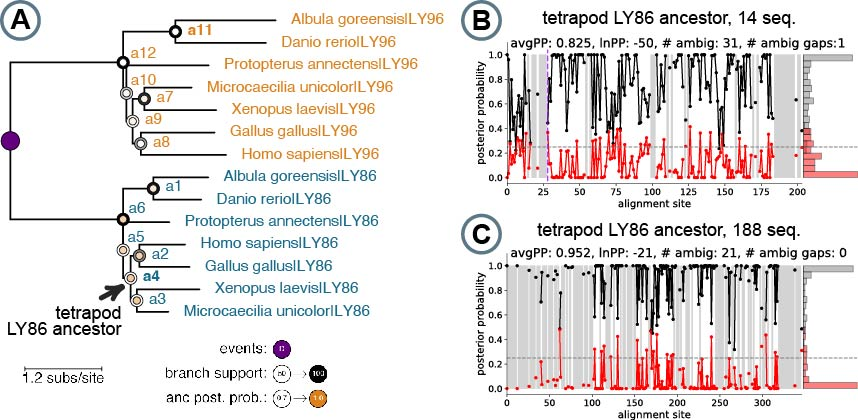

**Figure 1: Graphs for evaluating ancestor quality.** **(A)** The final bootstrap supported gene-species reconciled tree built from an example set of 14 sequences. Reconstructed ancestral sequences at each node are labeled with a unique name. Duplication events are marked in purple. Each node is labeled with a circle whose inner color represents the sequence’s average posterior probability (orange color gradient). The level of branch support from bootstrapping analysis is denoted by the ring around each node circle (black color gradient). Branch lengths represent the average number of amino acid substitutions per site and can be estimated using the scale bar. **(B and C):** Ancestor summary plots written out by topiary. The black points show the probability of the most likely amino acid at each position. The distribution of these probabilities is given by the histogram on the right. The average posterior probability is the mean of these values. The red points show the probability of the second most likely amino acid at each position, with its distribution on the right. The horizontal dashed line shows the minimum PP cutoff for the altAll reconstruction. Shaded gray regions indicate gaps; vertical purple dashed lines represent ambiguously gapped positions. **(B)** Summary for anc4 (tetrapod LY86 ancestor) for the 14-sequence alignment (see arrow in A). **(C)** Summary for the equivalent ancestor from an 188-sequence alignment and phylogenetic tree for LY86/LY96.
